# Import

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import copy
import torch
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.butterfly_module import GraceLitModule
from src.models.components.butterfly_net import ButterflyNet
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Helper Functions

In [2]:
torch.set_default_device('cuda')
torch.set_default_dtype(d=torch.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

def min_max_scaler(arr, min_val, max_val):
    scaled_arr = 2 * (arr - min_val) / (max_val - min_val) - 1
    return scaled_arr

def preprocess_csv(data_dir, val_size=0.3):
        # Read CSV
        df = pd.read_csv(data_dir)

        # Add Cmd of Current Time Step
        df['cmd_lnt_t'] = np.array(len(df)*[-13])
        df['cmd_lnp_t'] = np.array(len(df)*[-40])
        df['cmd_unt_t'] = np.array(len(df)*[44])
        df['cmd_lep_t'] = np.array(len(df)*[-18])
        df['cmd_rep_t'] = np.array(len(df)*[-18])
        df['cmd_et_t'] = np.array(len(df)*[22])
        
        # Reorganizing DataFrame
        data_df = pd.DataFrame({
            'l_rvec_0': df['l_rvec_0'].values,
            'l_rvec_1': df['l_rvec_1'].values,
            'l_rvec_2': df['l_rvec_2'].values,
            'l_tvec_0': df['l_tvec_0'].values,
            'l_tvec_1': df['l_tvec_1'].values,
            'l_tvec_2': df['l_tvec_2'].values,
            'r_rvec_0': df['r_rvec_0'].values,
            'r_rvec_1': df['r_rvec_1'].values,
            'r_rvec_2': df['r_rvec_2'].values,
            'r_tvec_0': df['r_tvec_0'].values,
            'r_tvec_1': df['r_tvec_1'].values,
            'r_tvec_2': df['r_tvec_2'].values,
            'cmd_lnt_t': df['cmd_lnt_t'].values,
            'cmd_lnt_tplus1': df['cmd_theta_lower_neck_tilt'].values,
            'cmd_lnp_t': df['cmd_lnp_t'].values,
            'cmd_lnp_tplus1': df['cmd_theta_lower_neck_pan'].values,
            'cmd_unt_t': df['cmd_unt_t'].values,
            'cmd_unt_tplus1': df['cmd_theta_upper_neck_tilt'].values,
            'cmd_et_t': df['cmd_et_t'].values,
            'cmd_et_tplus1': df['cmd_theta_eyes_tilt'].values,
            'cmd_lep_t': df['cmd_lep_t'].values,
            'cmd_lep_tplus1': df['cmd_theta_left_eye_pan'].values,
            'cmd_rep_t': df['cmd_rep_t'].values,
            'cmd_rep_tplus1': df['cmd_theta_right_eye_pan'].values,
        })
        
        # Minmax Feature Scaler
        feature_ranges = {
            'l_tvec_0': (-1.5, 1.5),  
            'l_tvec_1': (-1.5, 1.5),  
            'l_tvec_2': (-1.5, 1.5),
            'r_tvec_0': (-1.5, 1.5),
            'r_tvec_1': (-1.5, 1.5),  
            'r_tvec_2': (-1.5, 1.5),
            'cmd_lnt_t': (-44, 44),
            'cmd_lnp_t': (-44, 44),
            'cmd_unt_t': (-44, 44),
            'cmd_et_t': (-44, 44),
            'cmd_lep_t': (-44, 44),
            'cmd_rep_t': (-44, 44),
            'cmd_lnt_tplus1': (-44, 44),  # Original Range: (-13, 31)   
            'cmd_lnp_tplus1': (-44, 44),
            'cmd_unt_tplus1': (-44, 44),  # Original Range: (-13, 44)
            'cmd_et_tplus1': (-44, 44),  # Original Range: (-31, 22)
            'cmd_lep_tplus1': (-44, 44),
            'cmd_rep_tplus1': (-44, 44),
        }

        # Separation of Training and Validation Set
        train_df, temp_df = train_test_split(data_df, test_size=val_size, random_state=42)
        val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)

        # Training Set
        X_train = torch.tensor(train_df.values, dtype=torch.float32)
        y_train = torch.tensor(train_df.values, dtype=torch.float32)
        train_dataset = TensorDataset(X_train, y_train)

        # Validation Set
        X_val = torch.tensor(val_df.values, dtype=torch.float32)
        y_val = torch.tensor(val_df.values, dtype=torch.float32)
        val_dataset = TensorDataset(X_val, y_val)
        
        # Test Set
        X_test = torch.tensor(test_df.values, dtype=torch.float32)
        y_test = torch.tensor(test_df.values, dtype=torch.float32)
        test_dataset = TensorDataset(X_test, y_test)
        
        # Create the scaled DataFrame
        scaled_test_df = test_df.copy()
        for col in test_df[feature_ranges.keys()].columns:
            col_min, col_max = feature_ranges[col]
            scaled_test_df[col] = 2 * (test_df[col] - col_min) / (col_max - col_min) - 1

        return test_df, scaled_test_df

# Error Histogram

In [3]:
csv_fn = '/home/jaynieles/dev/grace_dl/logs/fk/runs/2024-10-22_21-55-35/tensorboard/version_0/delta_output_analysis.csv'
csv_df = pd.read_csv(csv_fn)

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00,
        2.110e+02, 4.672e+03, 2.218e+03, 4.300e+01, 6.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

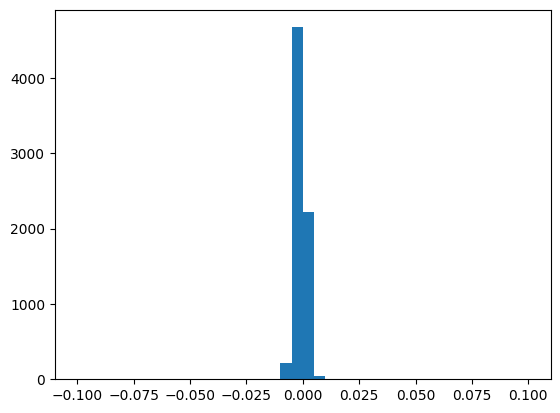

In [4]:
plt.hist(csv_df['delta_l_rvec_0'], bins=40, range=(-0.1,0.1))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.300e+01,
        3.930e+02, 3.800e+03, 2.751e+03, 1.930e+02, 5.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

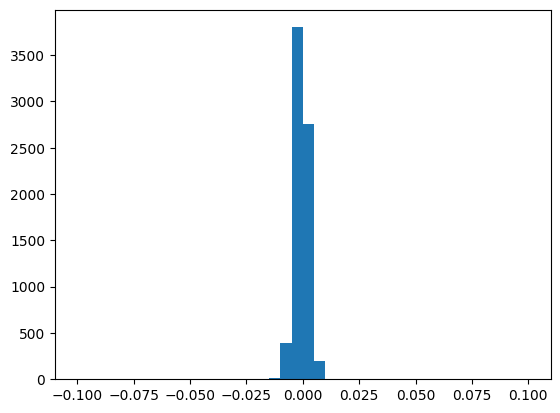

In [5]:
plt.hist(csv_df['delta_l_rvec_1'], bins=40, range=(-0.1,0.1))

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          15., 3821., 3308.,   12.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

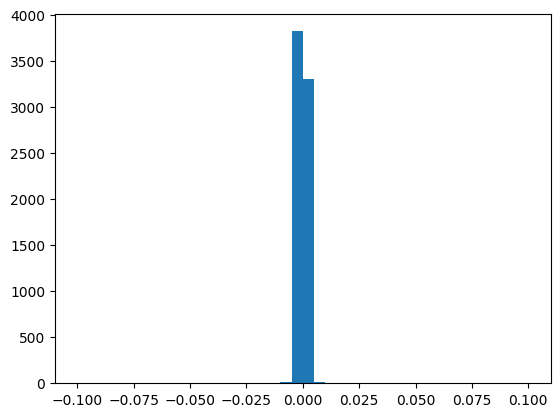

In [6]:
plt.hist(csv_df['delta_l_rvec_2'], bins=40, range=(-0.1,0.1))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        4.000e+01, 3.385e+03, 3.694e+03, 3.200e+01, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

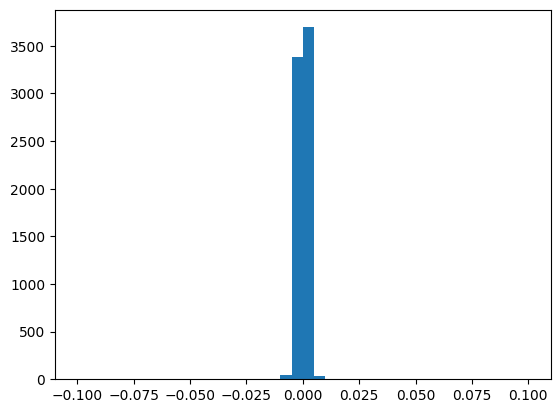

In [7]:
plt.hist(csv_df['delta_l_tvec_0'], bins=40, range=(-0.1,0.1))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.600e+01, 2.513e+03, 4.590e+03, 3.000e+01, 6.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

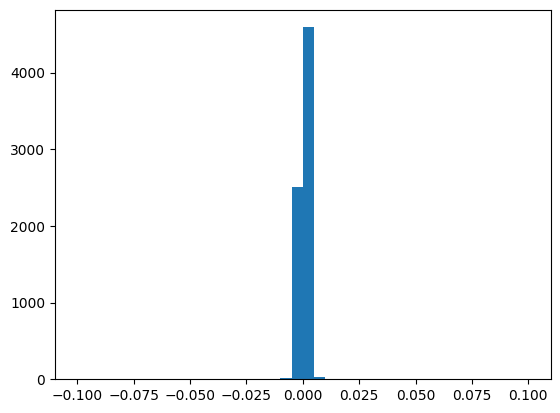

In [8]:
plt.hist(csv_df['delta_l_tvec_1'], bins=40, range=(-0.1,0.1))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+01, 4.959e+03, 2.186e+03, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

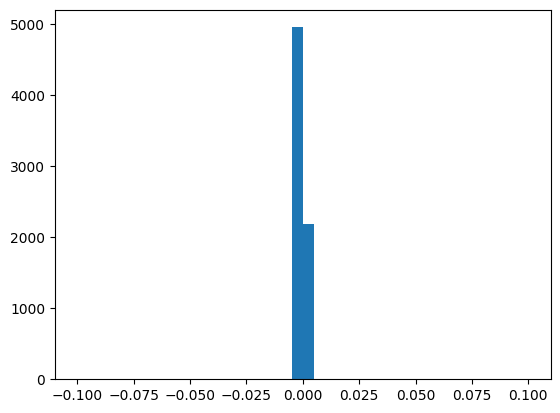

In [9]:
plt.hist(csv_df['delta_l_tvec_2'], bins=40, range=(-0.1,0.1))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.100e+01,
        2.540e+02, 4.675e+03, 2.170e+03, 3.700e+01, 7.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

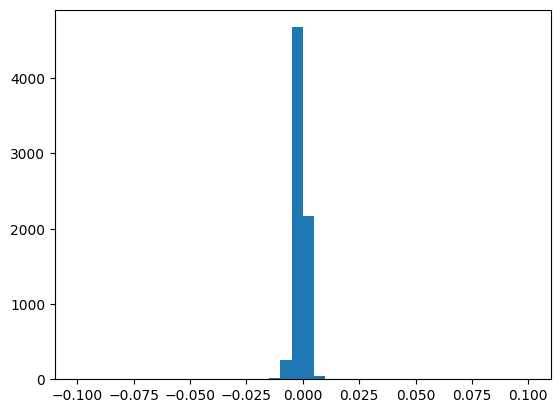

In [10]:
plt.hist(csv_df['delta_r_rvec_0'], bins=40, range=(-0.1,0.1))

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   13.,
         284., 3479., 3165.,  203.,   12.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

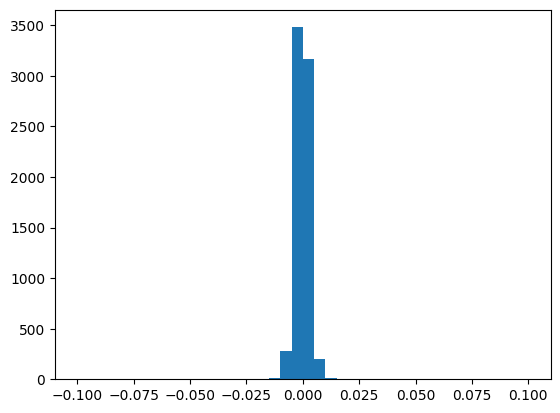

In [11]:
plt.hist(csv_df['delta_r_rvec_1'], bins=40, range=(-0.1,0.1))

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           9., 3880., 3261.,    6.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

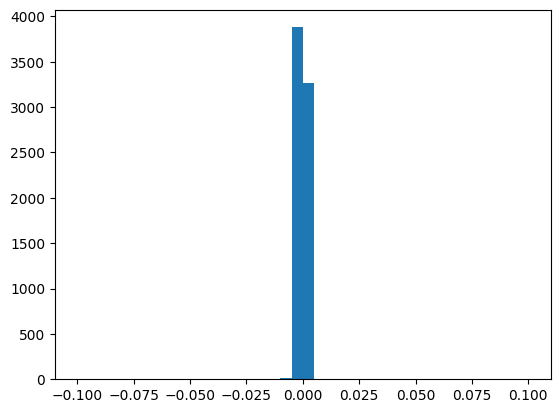

In [12]:
plt.hist(csv_df['delta_r_rvec_2'], bins=40, range=(-0.1,0.1))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        4.700e+01, 4.637e+03, 2.443e+03, 2.600e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

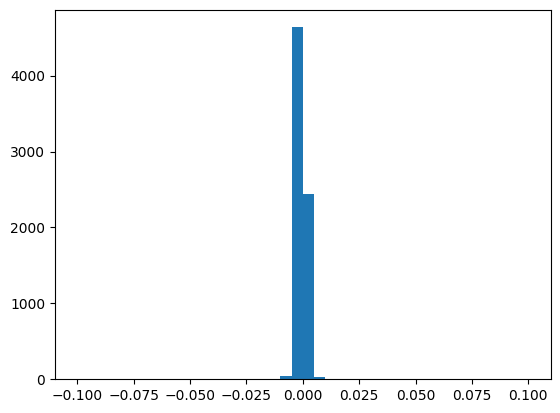

In [13]:
plt.hist(csv_df['delta_r_tvec_0'], bins=40, range=(-0.1,0.1))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00,
        4.300e+01, 3.136e+03, 3.937e+03, 3.300e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

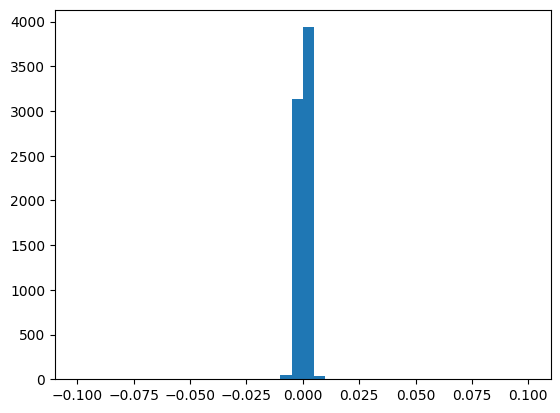

In [14]:
plt.hist(csv_df['delta_r_tvec_1'], bins=40, range=(-0.1,0.1))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 3.910e+03, 3.241e+03, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 <BarContainer object of 40 artists>)

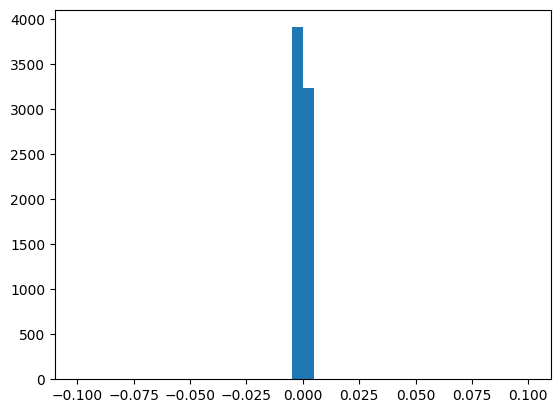

In [15]:
plt.hist(csv_df['delta_r_tvec_2'], bins=40, range=(-0.1,0.1))

# Load Dataset

In [ ]:
test_df, scaled_test_df = preprocess_csv("/home/jaynieles/dev/grace_dl/data/thesis/241003_075m_grace_dataset.csv")
test_df

In [ ]:
# Test Set

X_test = torch.tensor(scaled_test_df.values, dtype=torch.float32, device=device)
y_test = torch.tensor(scaled_test_df.values, dtype=torch.float32, device=device)
test_dataset = TensorDataset(X_test, y_test)

test_dataloader = DataLoader(
            dataset=test_dataset
        )

# Load ANN Model

In [ ]:
ckpt_path = '/home/jaynieles/dev/grace_dl/logs/initial_butterfly/runs/2024-10-20_23-05-46/checkpoints/epoch_137.ckpt'

In [ ]:
model = GraceLitModule.load_from_checkpoint(ckpt_path)

In [ ]:
model.eval()
# Output of DNN
with torch.no_grad():
    output = model(X_test)
    output1,output2,latent1,latent2 = output

In [ ]:
idx = 100
print('==rvec tvec==')
print('true:',y_test[idx][:12].cpu().numpy())
print('input:',X_test[idx][:12].cpu().numpy())
print('output:',output1[idx].cpu().numpy())
print('==motor cmds==')
print('true:',y_test[idx][12:].cpu().numpy())
print('input:',X_test[idx][12:].cpu().numpy())
print('output:',output2[idx].cpu().numpy())
print('==latent==')
print('latent1:', latent1[idx].cpu().numpy())
print('latent2:', latent2[idx].cpu().numpy())